uSO DE LA BASE DE DATOS DE HARVARD e implementacion de otras metricas como el recall

In [25]:
#matriz de confusión
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [26]:
import torch
print("¿GPU disponible?:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")


¿GPU disponible?: True
Nombre de la GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [27]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Definir transformaciones para aumentar los datos
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño estándar de ResNet50
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización
])

# Cargar datos
# Definir directorios
base_dir = r"C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final"  # Cambia esto a la ubicación de tus datos
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Crear DataLoaders para entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Clases
print("Clases:", train_dataset.classes)


Clases: ['benign_images', 'malignant_combined']


In [28]:
import torch.nn as nn
import torchvision.models as models

# Cargar modelo preentrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = model.to(device)

# Modificar la última capa para 2 clases (benigno vs maligno)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # 1 neurona para clasificación binaria
model.fc = model.fc.to(device)

print(model)


Dispositivo: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(

In [29]:
import torch.optim as optim

# Definir función de pérdida y optimizador
criterion = nn.BCEWithLogitsLoss()  # Usa sigmoid internamente
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [30]:
def train_model(model, train_loader, criterion, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        true_positives = 0
        predicted_positives = 0
        total_positives = 0  # <-- Nuevo: Total de ejemplos con label=1 en TODOS los batches

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            true_positives += ((preds == 1) & (labels == 1)).sum().item()
            predicted_positives += (preds == 1).sum().item()
            total_positives += (labels == 1).sum().item()  # <-- Acumulamos los positivos reales

        # Cálculo de métricas
        accuracy = 100 * correct / total
        recall = true_positives / (total_positives + 1e-6)  # Recall = TP / (TP + FN) = TP / total_positives_reales
        precision = true_positives / (predicted_positives + 1e-6)  # Precision = TP / (TP + FP)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Recall: {recall:.4f}, "
              f"Precision: {precision:.4f}, F1 Score: {f1_score:.4f}")

    print("Entrenamiento completado")

# Entrenar el modelo

train_model(model, train_loader, criterion, optimizer, epochs=30)

Epoch 1/30, Loss: 0.1771, Accuracy: 92.98%, Recall: 0.9096, Precision: 0.9478, F1 Score: 0.9283
Epoch 2/30, Loss: 0.1136, Accuracy: 95.52%, Recall: 0.9393, Precision: 0.9701, F1 Score: 0.9545
Epoch 3/30, Loss: 0.0946, Accuracy: 96.21%, Recall: 0.9512, Precision: 0.9724, F1 Score: 0.9617
Epoch 4/30, Loss: 0.0754, Accuracy: 96.96%, Recall: 0.9611, Precision: 0.9777, F1 Score: 0.9693
Epoch 5/30, Loss: 0.0686, Accuracy: 97.67%, Recall: 0.9703, Precision: 0.9829, F1 Score: 0.9766
Epoch 6/30, Loss: 0.0593, Accuracy: 97.67%, Recall: 0.9723, Precision: 0.9809, F1 Score: 0.9766
Epoch 7/30, Loss: 0.0405, Accuracy: 98.52%, Recall: 0.9824, Precision: 0.9880, F1 Score: 0.9852
Epoch 8/30, Loss: 0.0386, Accuracy: 98.49%, Recall: 0.9824, Precision: 0.9873, F1 Score: 0.9848
Epoch 9/30, Loss: 0.0304, Accuracy: 98.80%, Recall: 0.9869, Precision: 0.9891, F1 Score: 0.9880
Epoch 10/30, Loss: 0.0472, Accuracy: 98.56%, Recall: 0.9845, Precision: 0.9867, F1 Score: 0.9856
Epoch 11/30, Loss: 0.0345, Accuracy: 98

In [31]:

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.show()

In [32]:

# Evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()  # Modo evaluación
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()
            preds = torch.round(torch.sigmoid(outputs))  # Convertir logits en 0 o 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

                    precision    recall  f1-score   support

     benign_images       0.93      0.97      0.95       908
malignant_combined       0.79      0.61      0.69       171

          accuracy                           0.91      1079
         macro avg       0.86      0.79      0.82      1079
      weighted avg       0.91      0.91      0.91      1079



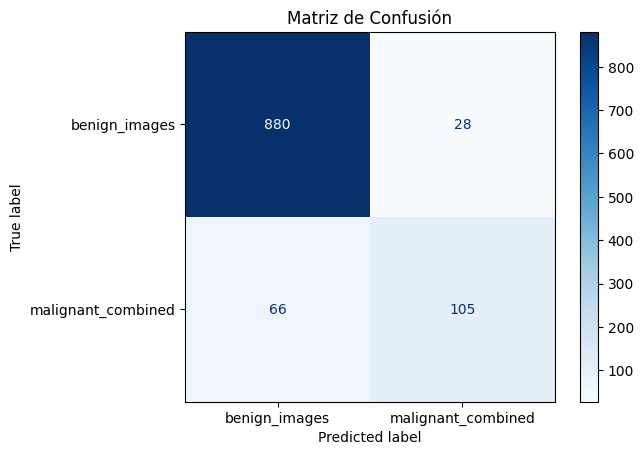

In [33]:

# Evaluar el modelo
all_labels, all_preds = evaluate_model(model, test_loader)
# Imprimir métricas
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
# Graficar matriz de confusión
plot_confusion_matrix(all_labels, all_preds, classes=train_dataset.classes)

In [34]:
torch.save(model.state_dict(), 'melanoma_model_1_torch_RESNET50_harvard.pth')

In [39]:
import cv2
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0).to(device)  # Aplicar las mismas transformaciones

    with torch.no_grad():
        output = model(img).squeeze()
        prediction = torch.sigmoid(output).item()
    
    if prediction > 0.5:
        print("🔴 MAlignant melanoma")
    else:
        print("🟢 Benign melanoma")

# Prueba con una imagen nueva


predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\train\benign_images\ISIC_0024306.jpg', model)#benigno
predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\test\malignant_images\ISIC_0034529.jpg', model)#malignant


🟢 Benign melanoma
🔴 MAlignant melanoma


Predicted class: 1.0


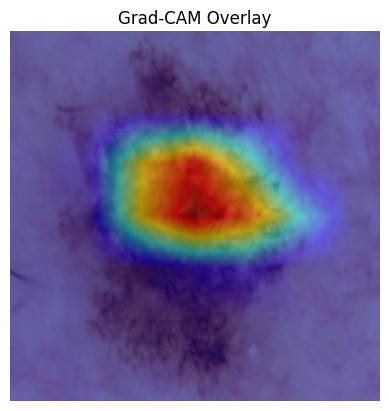

In [45]:
# implementacion gradcam
import torch
import torch.nn.functional as F
import numpy as np
#clase GradCam

class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks for gradients and activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        return self.model(x)

    def get_cam(self):
        # Ensure gradients and activations are available
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations are not available. Perform a backward pass first.")

        # Move gradients and activations to the same device
        device = self.activations.device
        gradients = self.gradients.to(device)

        # Global Average Pooling
        weights = torch.mean(gradients, dim=[0, 2, 3])
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32, device=device)

        for i in range(weights.shape[0]):
            cam += weights[i] * self.activations[0, i, :, :]

        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        return cam.cpu().detach().numpy()
# Load the model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 1)  # 1 neuron for binary classification
model.load_state_dict(torch.load('melanoma_model_1_torch_RESNET50_harvard.pth'))
model.eval()
model.to(device)
# Get the target layer
target_layer = model.layer4[2].conv3  # Last convolutional layer
# Create the GradCam object
grad_cam = GradCam(model, target_layer)
# Load and preprocess the image
image_path = r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\test\malignant_images\ISIC_0034529.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0).to(device)  # Apply the same transformations
# Forward pass
output = model(image)
# Get the predicted class
predicted_class = torch.round(torch.sigmoid(output)).item()
print("Predicted class:", predicted_class)
# Backward pass
output[0, 0].backward()  # Backpropagate the score for the predicted class
# Get the gradients and activations
gradients = grad_cam.gradients
activations = grad_cam.activations
# Get the CAM
cam = grad_cam.get_cam()
# Resize the CAM to the original image size
original_image = Image.open(image_path)
original_image = original_image.resize((224, 224))
cam = cv2.resize(cam, (original_image.size[0], original_image.size[1]))
# Normalize the CAM
cam = cam - np.min(cam)
cam = cam / np.max(cam)
# Convert the CAM to a heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
# Convert the heatmap to BGR
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
# Convert the original image to numpy array
original_image = np.array(original_image)
# Overlay the heatmap on the original image
overlay = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)
# Display the overlay
plt.imshow(overlay)
plt.axis('off')
plt.title("Grad-CAM Overlay")
plt.show()
